# Introduction

Modeling (?) have not gotten case study objective yet

# Notes

1. year in `award_date` and `revenue_year` don't always align
- Why? idk yet

# Setup

In [149]:
# Enable autoreload for Python modules (e.g., scripts in the utils folder)
%load_ext autoreload
%autoreload 2

# === Standard Library Imports ===
import json
import os
import sys
from pathlib import Path

# === Third-Party Library Imports ===
import matplotlib.pyplot as plt
# import numpy as np (not used)
import pandas as pd
import seaborn as sns

# === Local Project-Specific Imports ===
# Add project root to the Python path
root_path = os.path.abspath("../")
if root_path not in sys.path:
    sys.path.append(root_path)

from src.utils import load_yaml, to_snake_case, clean_column_names, Timer

# Load environment variables from .env
from dotenv import load_dotenv
load_dotenv();

# Configure display options
pd.set_option("display.max_colwidth", None)
pd.set_option('display.max_rows', 20)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [150]:
# Start timer
timer = Timer()

# Load config

In [151]:
config = load_yaml("../config/data.yaml")

print(json.dumps(config, indent=4))

{
    "base_path": "../",
    "paths": {
        "raw_data": "data/00_raw/",
        "clean_data": "data/01_clean/",
        "output_data": "data/02_output/",
        "other_data": "data/99_other/"
    },
    "data": {
        "raw": {
            "path": "Quant_Take_Home.xlsx",
            "sheet": "Pipeline Data",
            "columns": {
                "Business Unit": "str",
                "Account Name": "str",
                "Opportunity Number": "int64",
                "Forecast Category": "str",
                "Award Date": "datetime64[ns]",
                "Revenue Amount": "float64",
                "Stage": "str",
                "Probability of Award": "float64",
                "Weighted Revenue Amount": "float64",
                "Type": "str",
                "Revenue Type": "str",
                "Revenue Year": "int64"
            }
        },
        "clean": {
            "path": "20250423_cleaned_data.csv",
            "columns": {
                "business_uni

# Pull data

In [152]:
# Build full path to the CSV file
base_path = Path(config["base_path"])
clean_data_path = base_path / config["paths"]["clean_data"]
csv_file = clean_data_path / config["data"]["clean"]["path"]
print("CSV file:", csv_file)

# Get clean columns
columns_config = config["data"]["clean"]["columns"]

# Separate dtypes and datetime columns
dtype_map = {}
parse_dates = []

for col, dtype in columns_config.items():
    if "datetime" in dtype:
        parse_dates.append(col)
    elif "string[python]" in dtype:
        dtype_map[col] = "string"
    else:
        dtype_map[col] = dtype

# Load the CSV
df = pd.read_csv(
    csv_file,
    sep=",",
    encoding="utf-8",
    low_memory=False,
    dtype=dtype_map,
    parse_dates=parse_dates
)

print(df.shape)
print(df.dtypes)

df.head()

CSV file: ../data/01_clean/20250423_cleaned_data.csv
(1309, 12)
business_unit              string[python]
account_name               string[python]
opportunity_number                  int64
forecast_category          string[python]
award_date                 datetime64[ns]
revenue_amount                    float64
stage                      string[python]
probability_of_award              float64
weighted_revenue_amount           float64
type                       string[python]
revenue_type               string[python]
revenue_year                        int64
dtype: object


business_unit                    account_name  opportunity_number  \
0             Maritime   Prometheus Defense Innovations               71201   
1                Radars         Inferno Protection Tech               31305   
2   Solid Rocket Motors        Vortex Security Dynamics               30977   
3  Command and Control          Maelstrom Defense Group               75064   
4  Command and Control      Vanguard Tactical Solutions               32256   

  forecast_category award_date  revenue_amount    stage  probability_of_award  \
0         Base Case 2029-08-25     195836453.0  Shaping                0.9023   
1         Base Case 2029-11-04     114991405.0  Shaping                0.9023   
2         Base Case 2029-11-29     151129327.0  Shaping                0.9023   
3         Base Case 2029-02-20     195003733.0  Shaping                0.7725   
4         Base Case 2029-12-14      23139092.0  Shaping                0.2430   

   weighted_revenue_amount          type revenue_type  revenue_year  
0             1.767032e+08     Follow-On          O&M          2029  
1             1.037567e+08  New Business      Product          2029  
2             1.363640e+08  New Business          O&M          2029  
3             1.506404e+08     Follow-On      Product          2029  
4             5.622799e+06  New Business  Development          2029

# Quick Checks

In [153]:
...

Ellipsis

# Basic Feature Engineering

In [154]:
# Extract month from award_date
# df["award_date"] = pd.to_datetime(df["award_date"], format="%Y-%m-%d", errors="coerce")
print(df["award_date"].dtypes)
print(df["award_date"].value_counts(dropna=False))

datetime64[ns]
award_date
2025-09-30    45
2027-06-30    30
2026-06-30    23
2026-03-31    22
2025-06-30    19
              ..
2026-02-15     1
2029-12-15     1
2027-09-24     1
2028-03-30     1
2027-02-05     1
Name: count, Length: 538, dtype: int64


In [155]:
# Verify that Year in 'award_date' is always equal to 'revenue_year'
df["award_date_year"] = df["award_date"].dt.year
print(df["award_date_year"].value_counts(dropna=False))
print(df["revenue_year"].value_counts(dropna=False))

df['check'] = df['award_date_year'] == df['revenue_year']
print(df['check'].value_counts(dropna=False))

# TODO: Figure this out
# assert df['check'].all(), "Mismatch between award_date_year and revenue_year"

award_date_year
2025    342
2027    260
2026    249
2029    235
2028    223
Name: count, dtype: int64
revenue_year
2025    344
2026    288
2027    240
2029    220
2028    217
Name: count, dtype: int64
check
True     1242
False      67
Name: count, dtype: int64


In [156]:
# Count NA in each column
na_counts = df.isna().sum()
na_counts = na_counts[na_counts > 0]
na_counts = na_counts.sort_values(ascending=False)
na_counts

Series([], dtype: int64)

In [157]:
# Create 'period' which is an integer representing the year + month (Today's would be 202504)
df["period"] = (df["award_date"].dt.year * 100 + df["award_date"].dt.month).astype(int)
print(df["period"].dtypes)
print(df["period"].value_counts(dropna=False))

int64
period
202509    53
202512    44
202603    39
202706    39
202506    38
          ..
202501    12
202712    11
202705    10
202702     8
202605     7
Name: count, Length: 60, dtype: int64


In [158]:
# temp: export data to clean csv in my Downloads folder
data_path = Path.home() / "Downloads" / "anduril_clean.csv"
df.to_csv(data_path, sep=",", encoding="utf-8", index=False)
print("Data exported to:", data_path)


Data exported to: /Users/thomasmyles/Downloads/anduril_clean.csv


# Advanced EDA

Multivariate plots, correlation matrix, pairwise scatter plots, and over time (ie. in relation to `revenue_year`)

In [159]:
# Multivariate plots

In [160]:
# Correlation matrix

In [161]:
# Pairwise plots

In [162]:
# Over time

In [163]:
del df['period']
del df['award_date_year']


------- Correlation Matrix -------



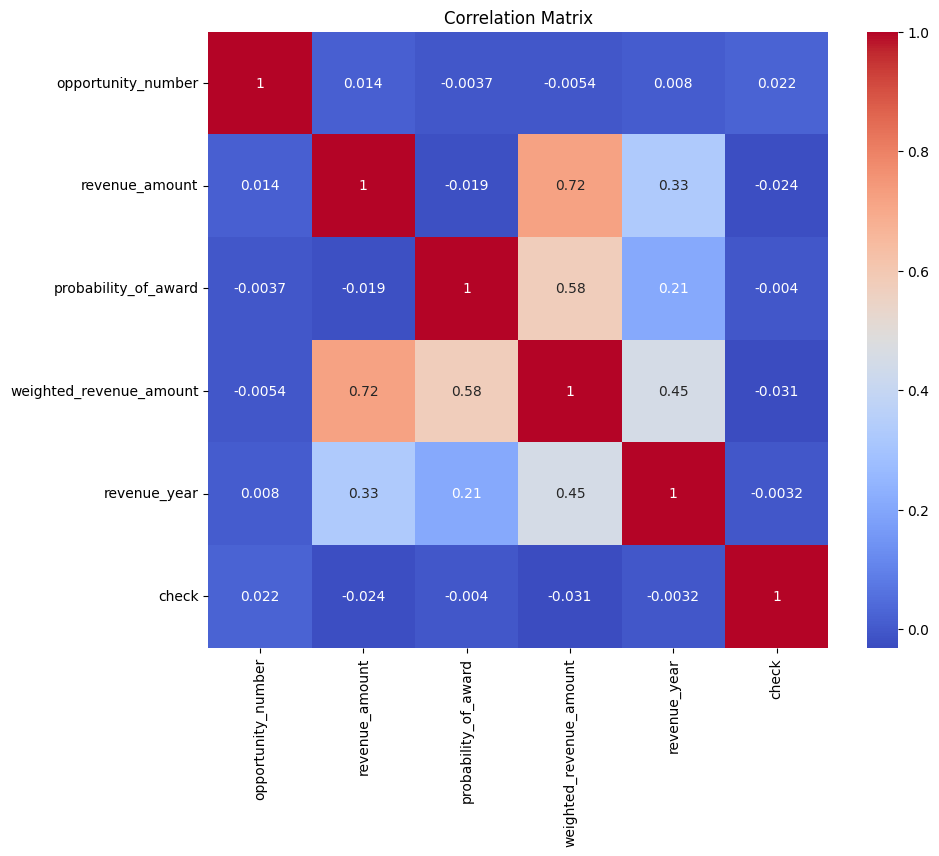


------- Pairwise Scatter Plots vs Revenue Amount -------

_____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

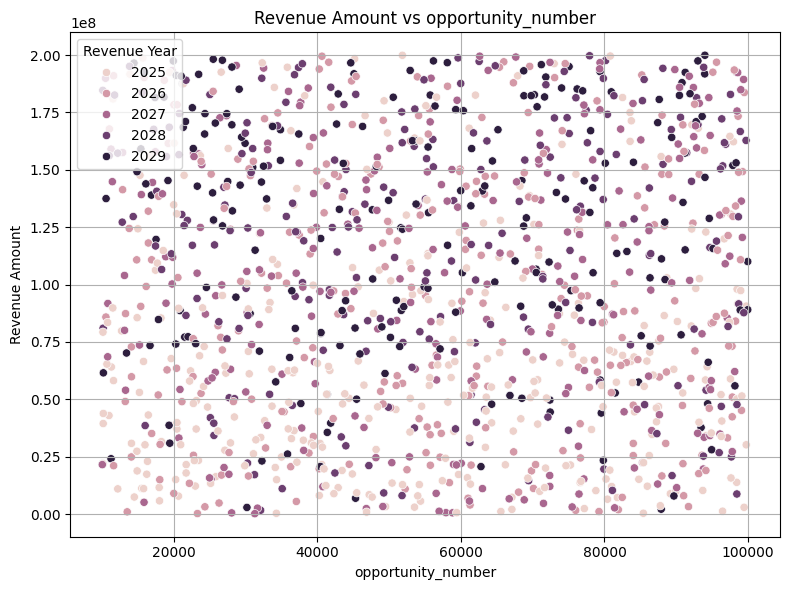


------- Plotting: Revenue Amount vs probability_of_award -------



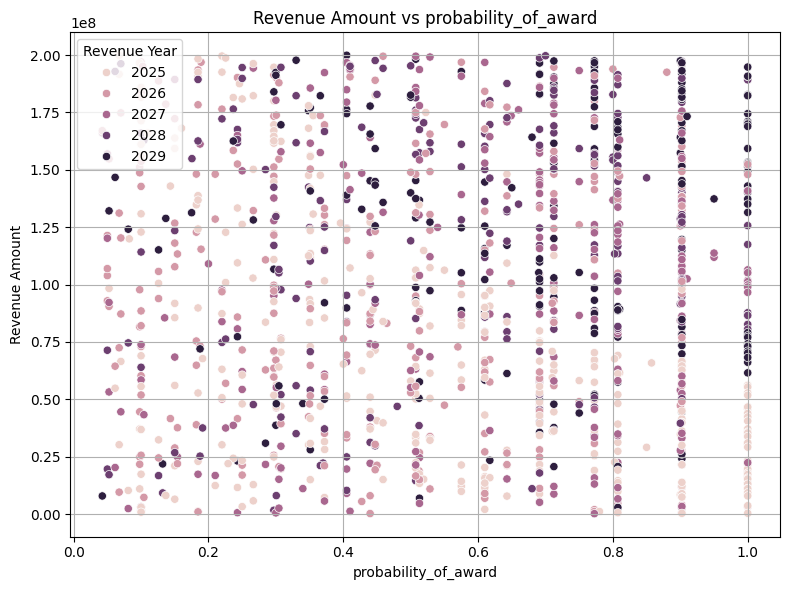


------- Plotting: Revenue Amount vs weighted_revenue_amount -------



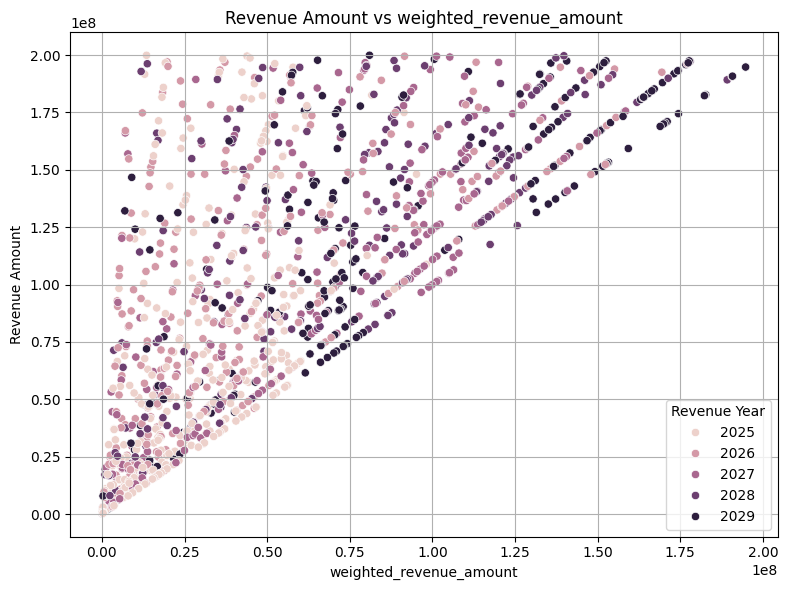

without hue... 


______________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

/var/folders/xy/8hvrs8m970qgw74212qdv2g00000gn/T/ipykernel_27970/2428101708.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Revenue Year")


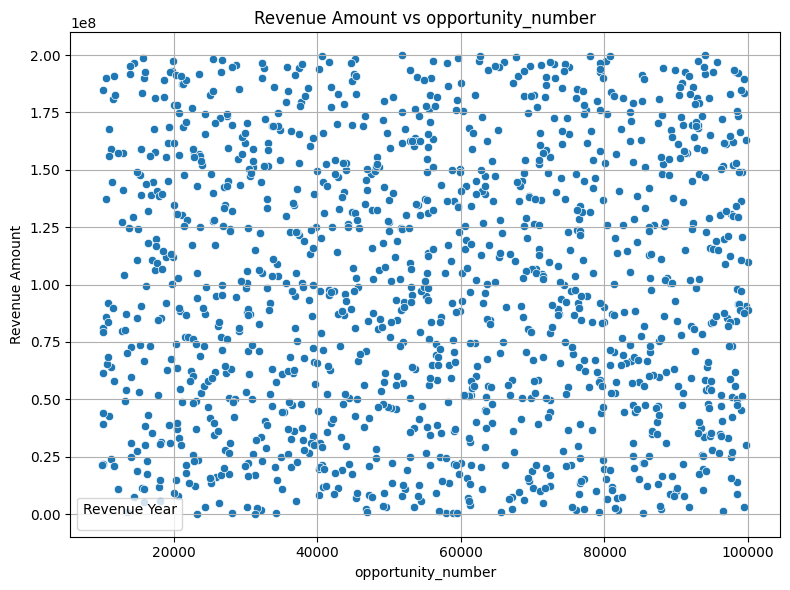


------- Plotting: Revenue Amount vs probability_of_award -------



/var/folders/xy/8hvrs8m970qgw74212qdv2g00000gn/T/ipykernel_27970/2428101708.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Revenue Year")


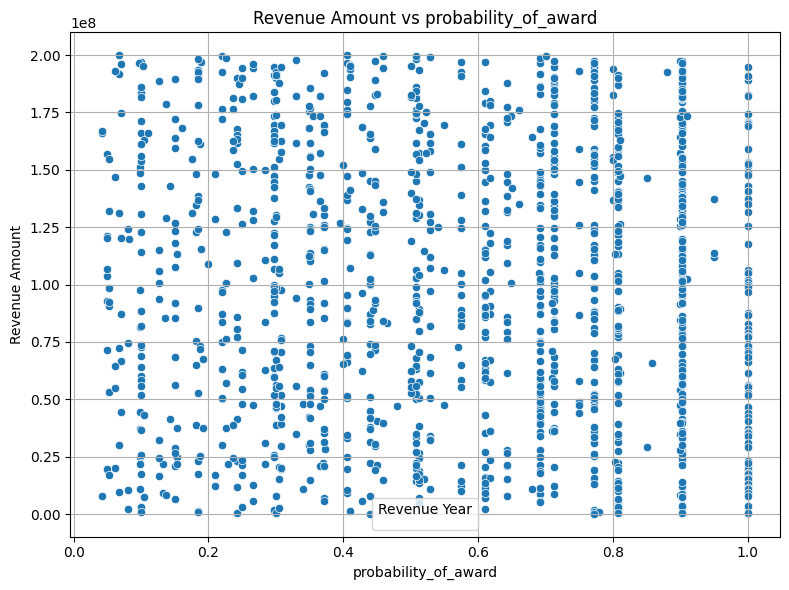


------- Plotting: Revenue Amount vs weighted_revenue_amount -------



/var/folders/xy/8hvrs8m970qgw74212qdv2g00000gn/T/ipykernel_27970/2428101708.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Revenue Year")


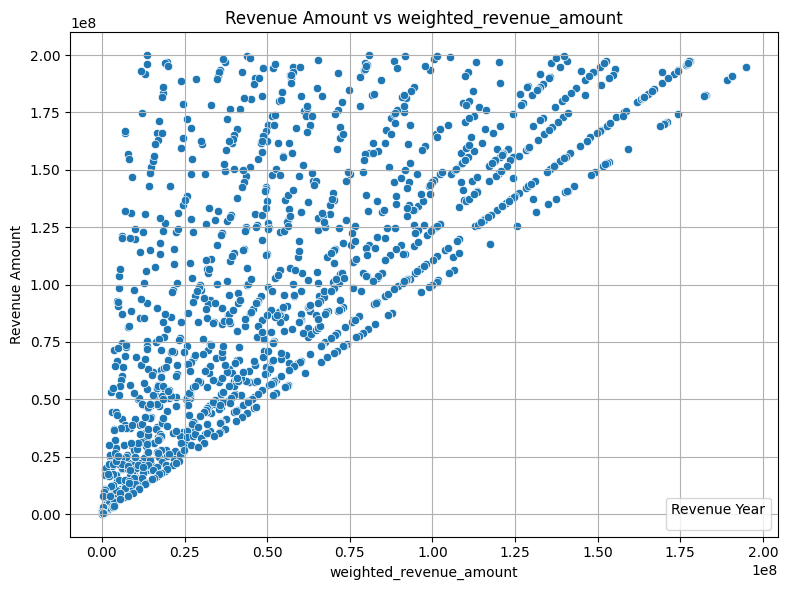


------- Trends Over Time (Grouped by Revenue Year) -------

___________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

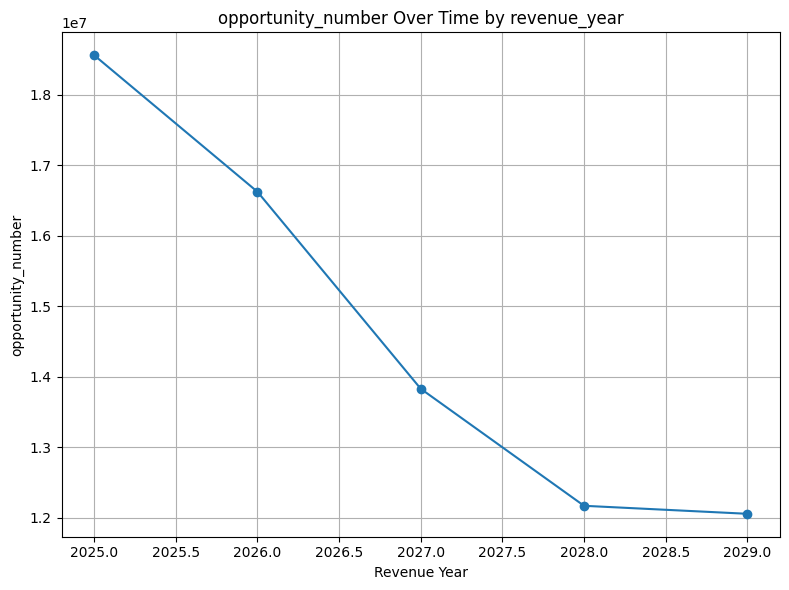


------- Plotting Trend: revenue_amount over revenue_year -------



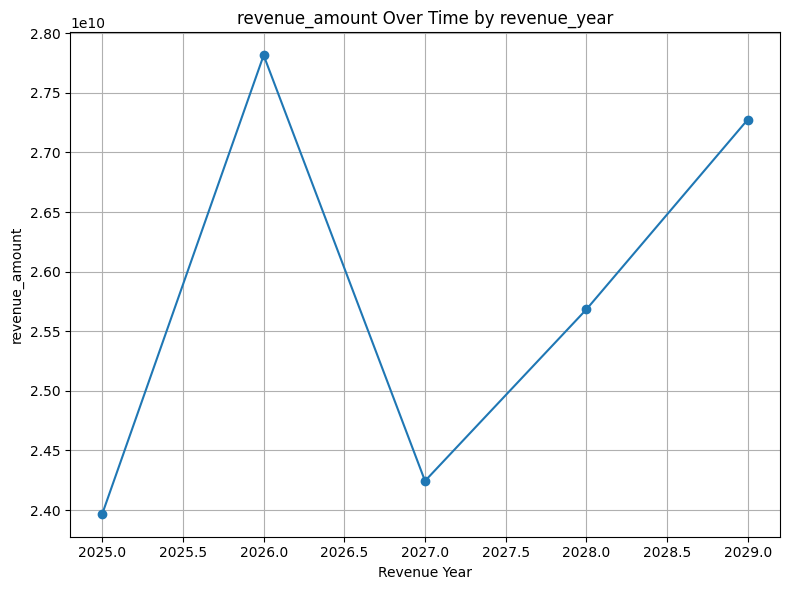


------- Plotting Trend: probability_of_award over revenue_year -------



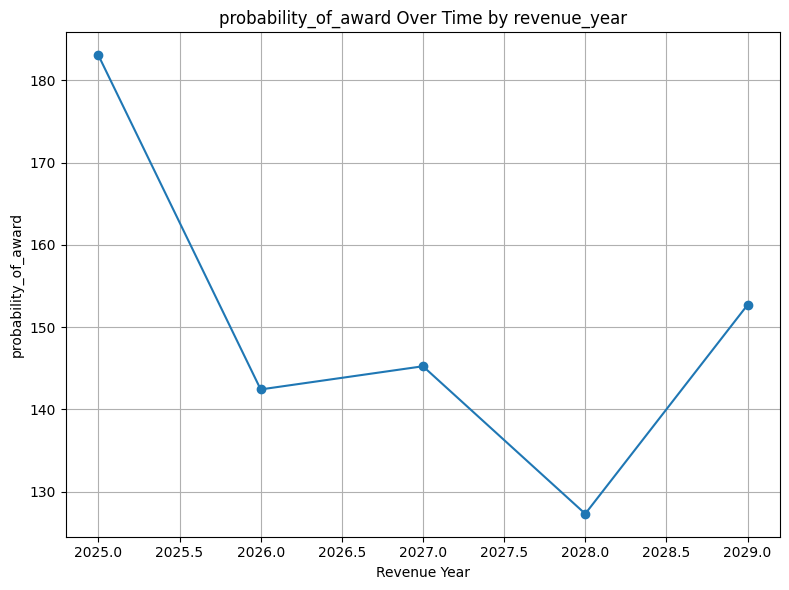


------- Plotting Trend: weighted_revenue_amount over revenue_year -------



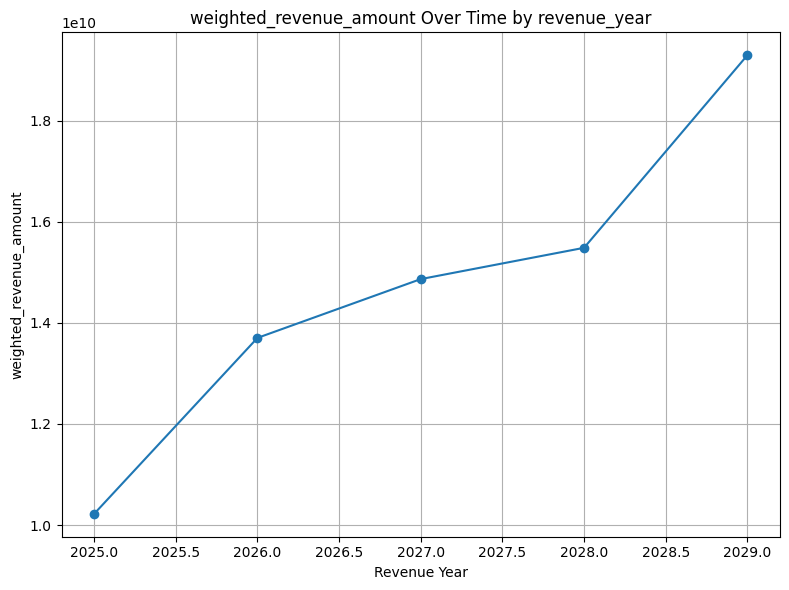

In [164]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Chunk 1: Correlation Matrix ---
print("\n------- Correlation Matrix -------\n")
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# --- Chunk 2: Pairwise Scatter Plots vs Revenue ---
print("\n------- Pairwise Scatter Plots vs Revenue Amount -------\n")
print("_" * 1000)
numeric_cols = df.select_dtypes(include='number').columns.tolist()
if 'revenue_amount' in numeric_cols:
    numeric_cols.remove('revenue_amount')  # Use this as target
if 'revenue_year' in numeric_cols:
    numeric_cols.remove('revenue_year')  # Use as hue

for col in numeric_cols:
    print(f"\n------- Plotting: Revenue Amount vs {col} -------\n")
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x=col, y='revenue_amount', hue='revenue_year')
    plt.title(f"Revenue Amount vs {col}")
    plt.xlabel(col)
    plt.ylabel("Revenue Amount")
    plt.legend(title="Revenue Year")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

print("without hue... \n\n")
print("_" * 1000)

for col in numeric_cols:
    print(f"\n------- Plotting: Revenue Amount vs {col} -------\n")
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x=col, y='revenue_amount')
    plt.title(f"Revenue Amount vs {col}")
    plt.xlabel(col)
    plt.ylabel("Revenue Amount")
    plt.legend(title="Revenue Year")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# --- Chunk 3: Trends Over Time ---
print("\n------- Trends Over Time (Grouped by Revenue Year) -------\n")
print("_" * 1000)
group_col = 'revenue_year'

for col in df.select_dtypes(include='number').columns:
    if col != group_col:
        print(f"\n------- Plotting Trend: {col} over {group_col} -------\n")
        trend_data = df.groupby(group_col)[col].sum().reset_index()
        plt.figure(figsize=(8, 6))
        plt.plot(trend_data[group_col], trend_data[col], marker='o')
        plt.title(f"{col} Over Time by {group_col}")
        plt.xlabel("Revenue Year")
        plt.ylabel(col)
        plt.grid(True)
        plt.tight_layout()
        plt.show()



------- 0) Multivariate Plots (Scatter with Hue) -------

_____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

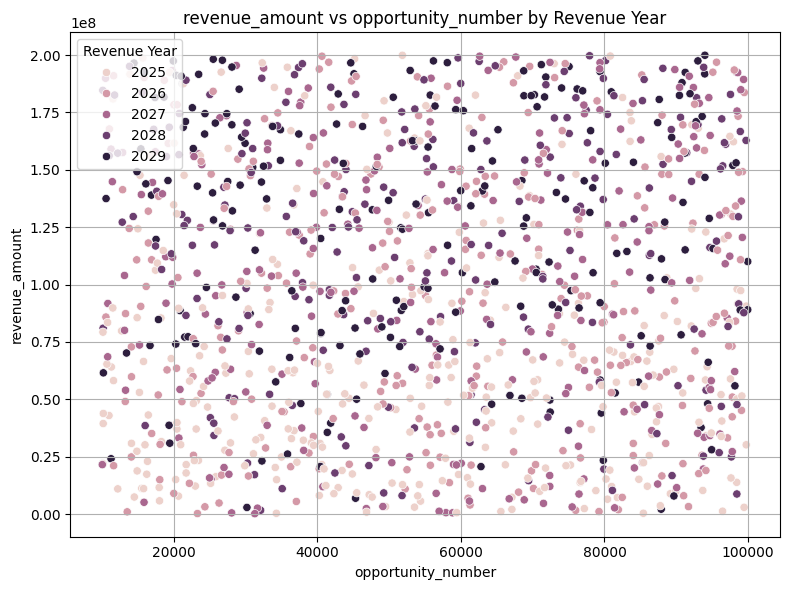


--- Multivariate: opportunity_number vs probability_of_award (Hue = revenue_year) ---



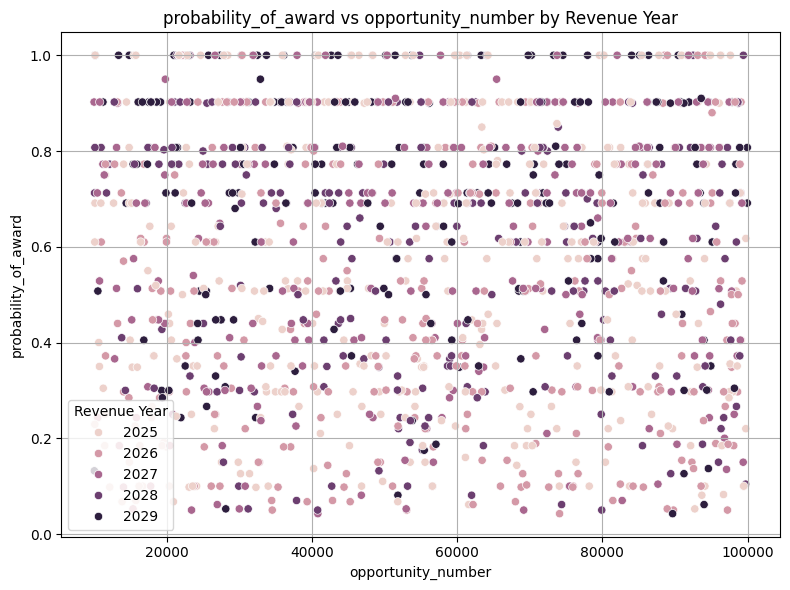


--- Multivariate: opportunity_number vs weighted_revenue_amount (Hue = revenue_year) ---



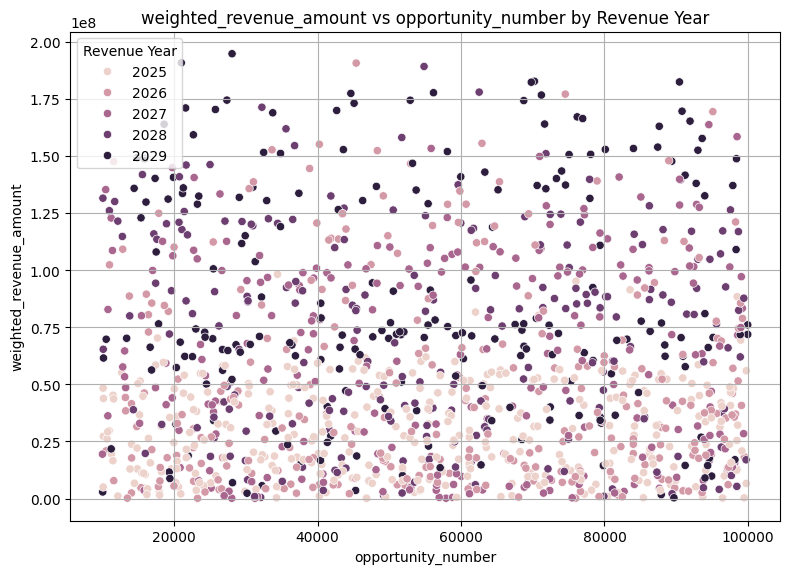


--- Multivariate: revenue_amount vs opportunity_number (Hue = revenue_year) ---



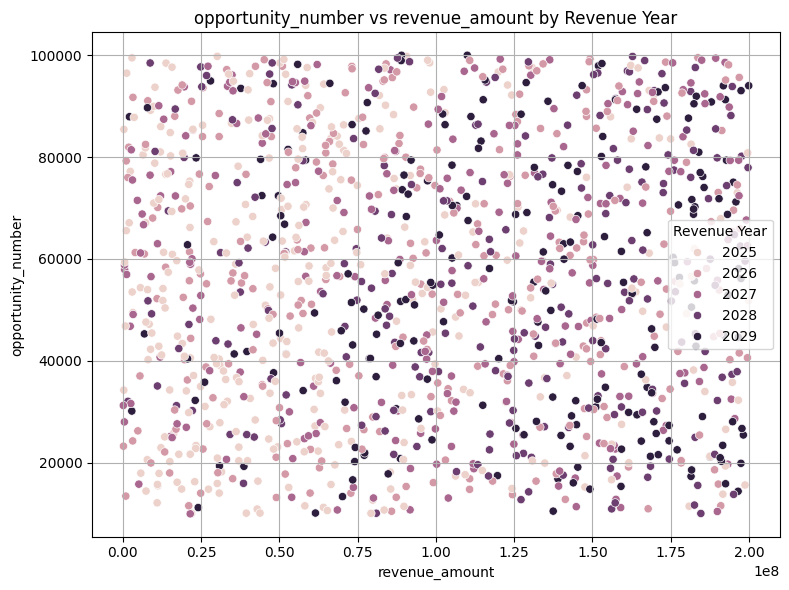


--- Multivariate: revenue_amount vs probability_of_award (Hue = revenue_year) ---



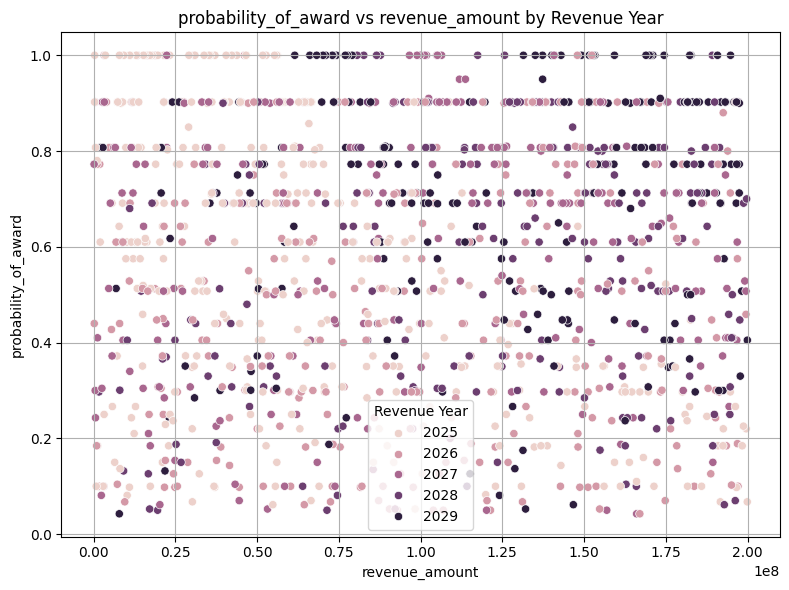


--- Multivariate: revenue_amount vs weighted_revenue_amount (Hue = revenue_year) ---



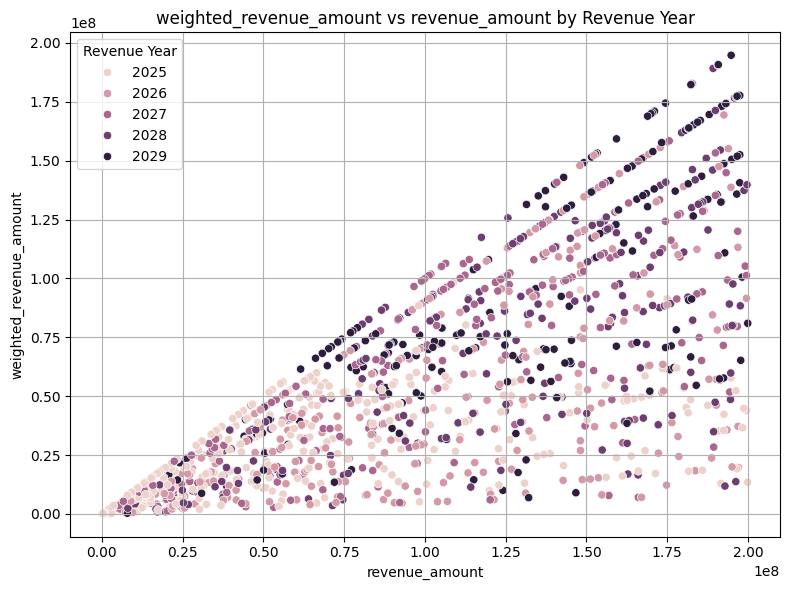


--- Multivariate: probability_of_award vs opportunity_number (Hue = revenue_year) ---



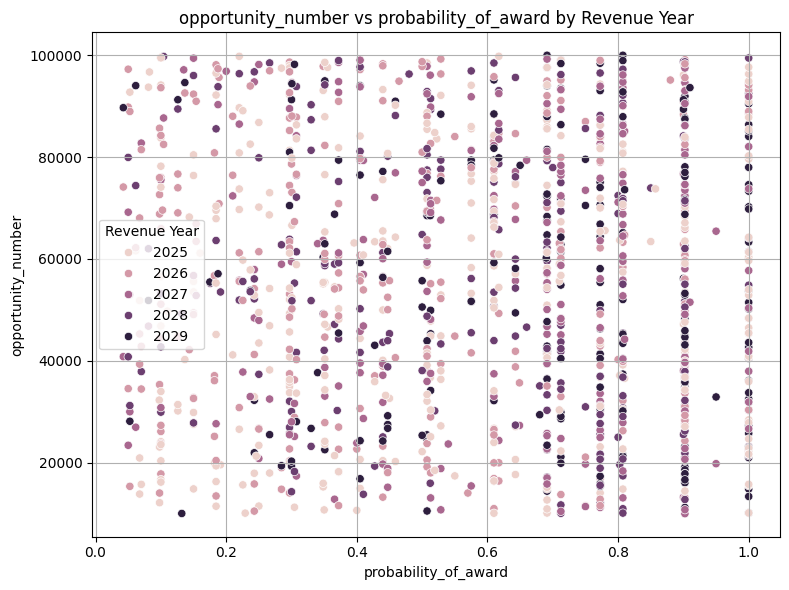


--- Multivariate: probability_of_award vs revenue_amount (Hue = revenue_year) ---



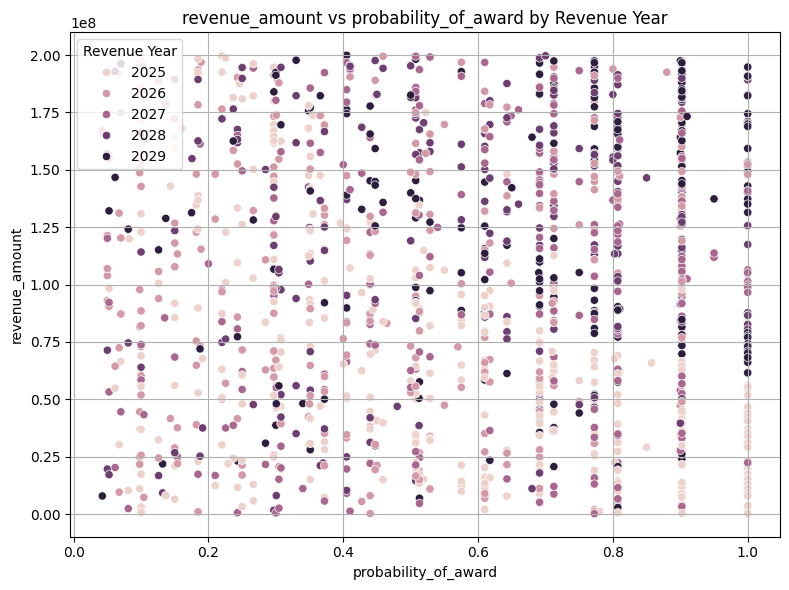


--- Multivariate: probability_of_award vs weighted_revenue_amount (Hue = revenue_year) ---



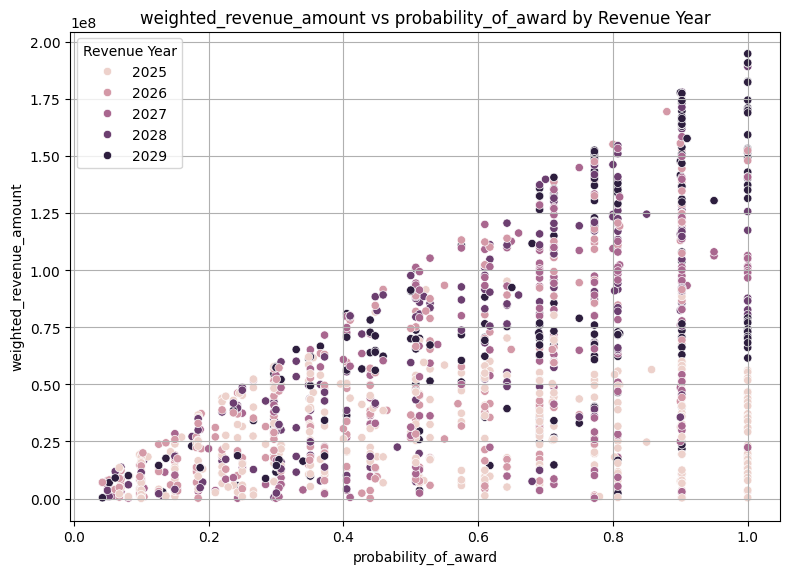


--- Multivariate: weighted_revenue_amount vs opportunity_number (Hue = revenue_year) ---



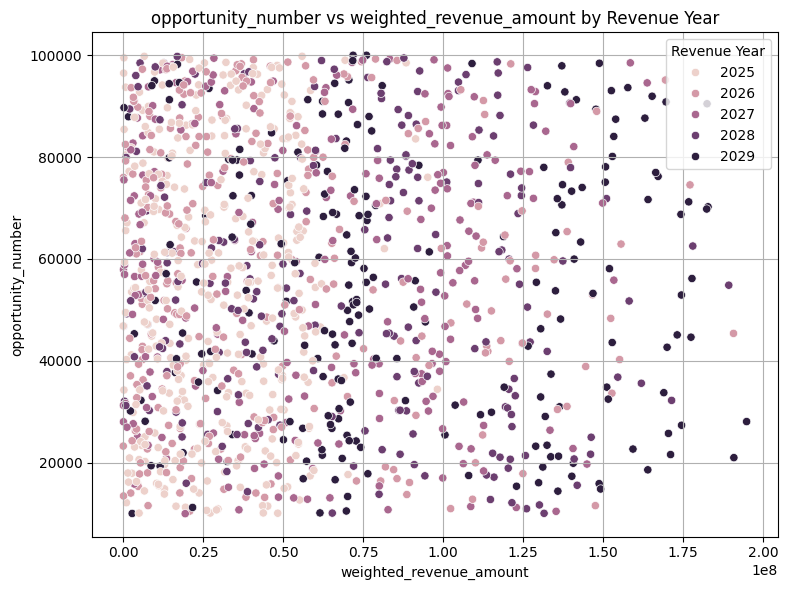


--- Multivariate: weighted_revenue_amount vs revenue_amount (Hue = revenue_year) ---



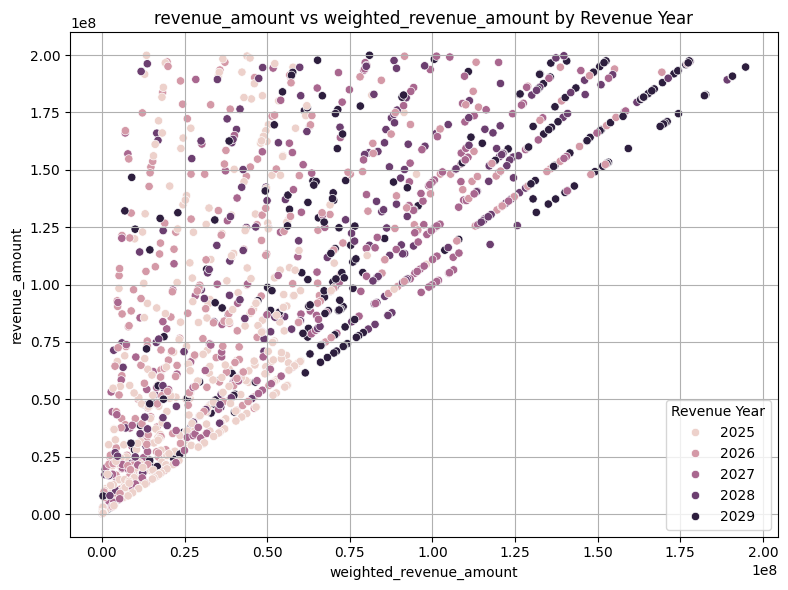


--- Multivariate: weighted_revenue_amount vs probability_of_award (Hue = revenue_year) ---



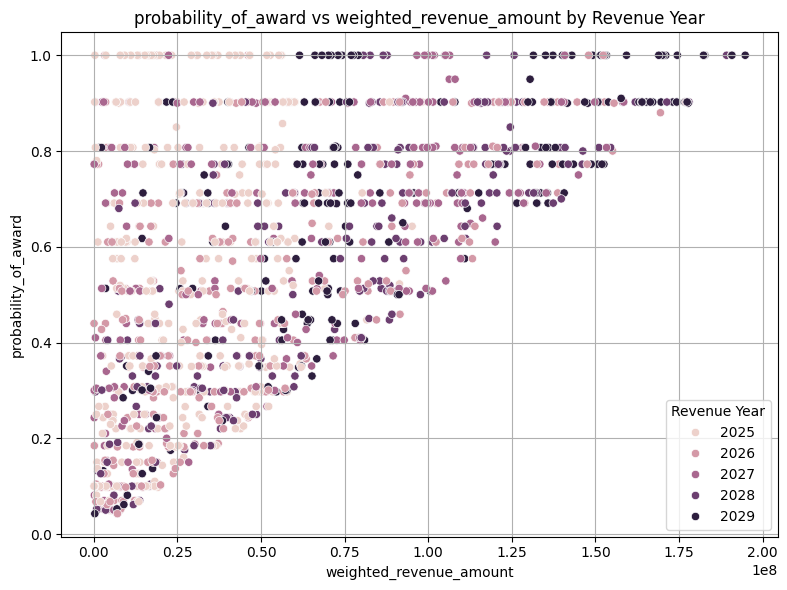


------- 1) Correlation Matrix -------

________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

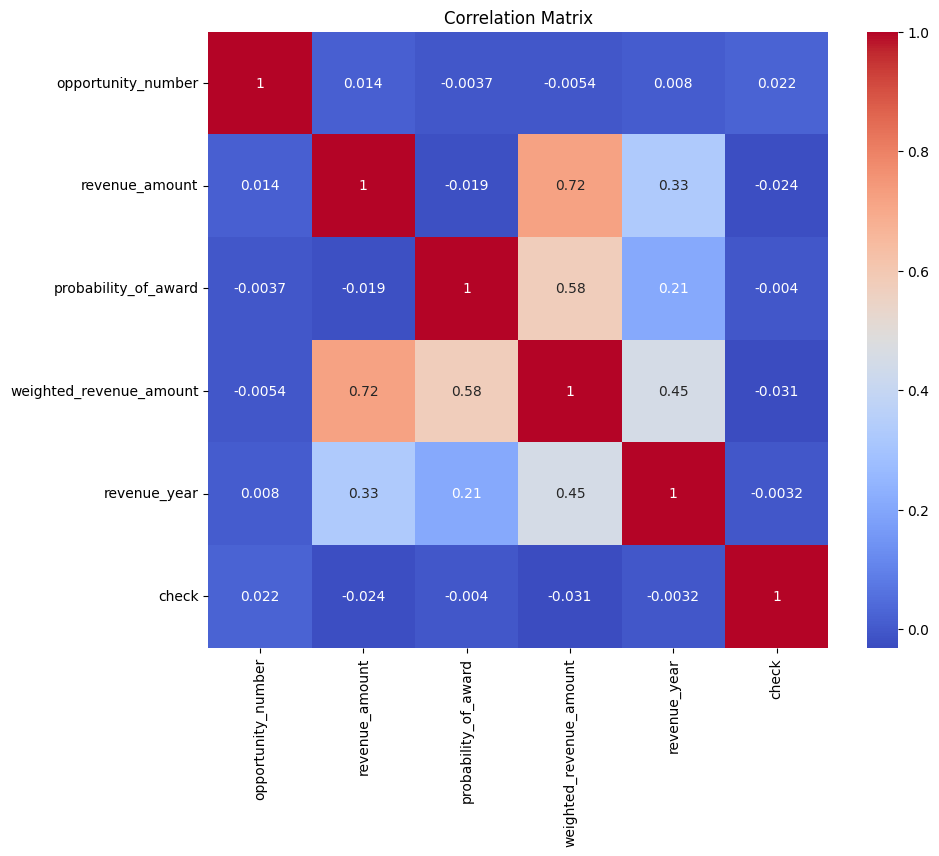


------- 2) Pairwise Scatter Plots vs Revenue Amount -------

__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

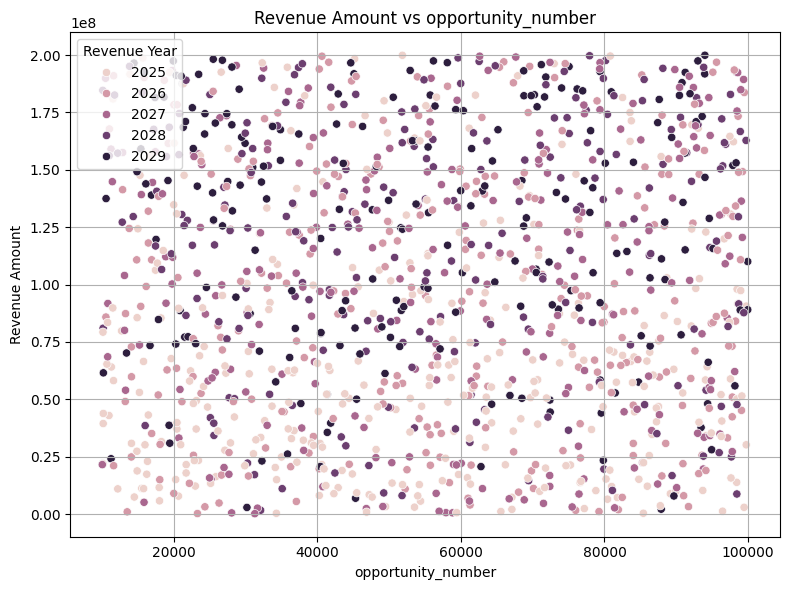


--- Revenue Amount vs probability_of_award ---



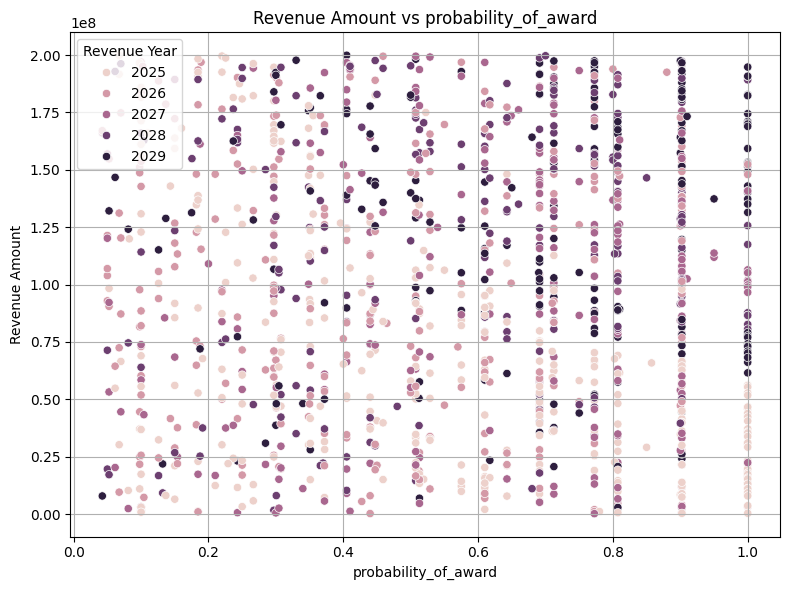


--- Revenue Amount vs weighted_revenue_amount ---



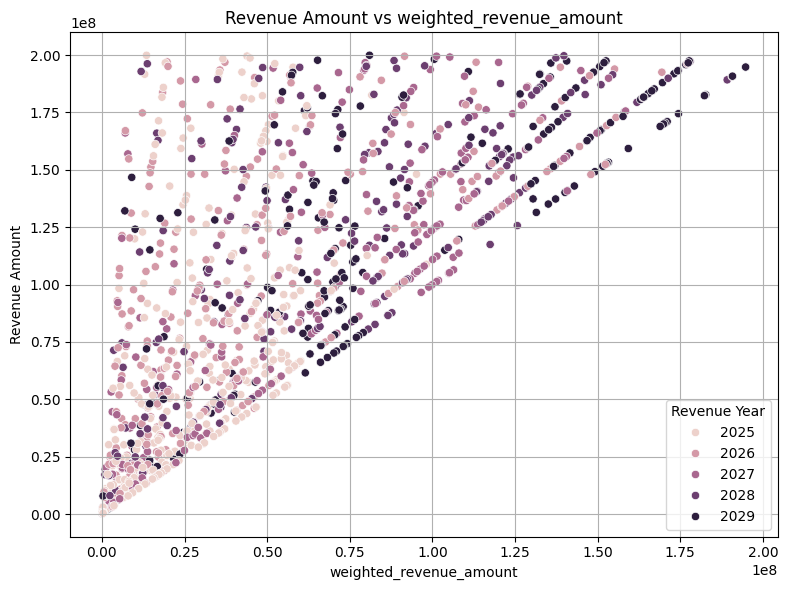

no hue...
______________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

/var/folders/xy/8hvrs8m970qgw74212qdv2g00000gn/T/ipykernel_27970/2957463690.py:73: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Revenue Year")


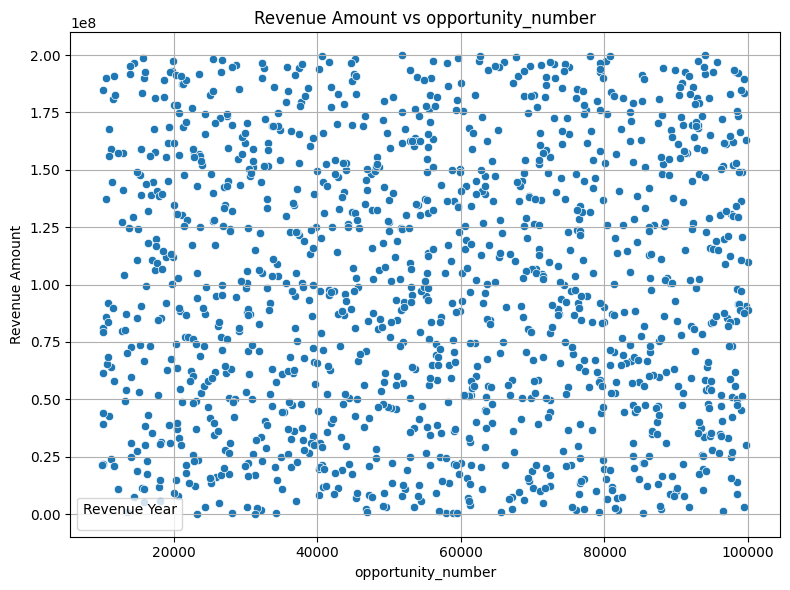


--- Revenue Amount vs probability_of_award ---



/var/folders/xy/8hvrs8m970qgw74212qdv2g00000gn/T/ipykernel_27970/2957463690.py:73: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Revenue Year")


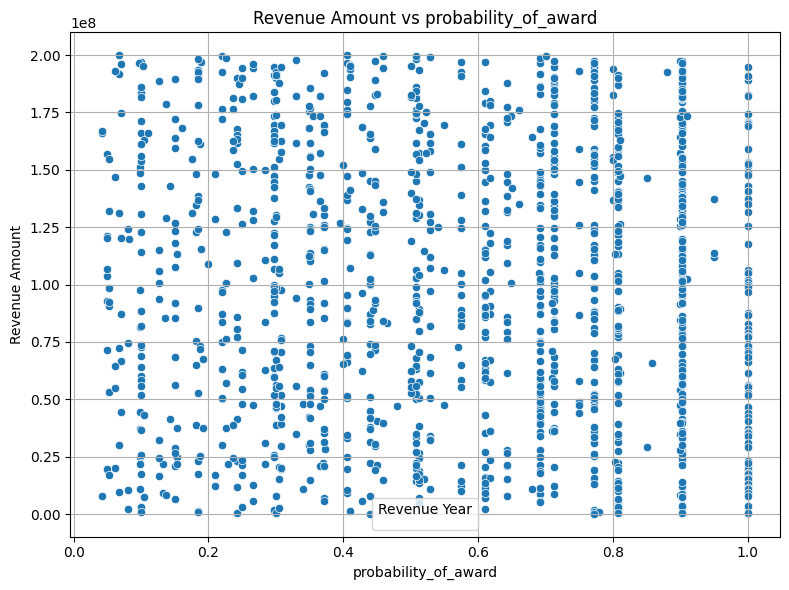


--- Revenue Amount vs weighted_revenue_amount ---



/var/folders/xy/8hvrs8m970qgw74212qdv2g00000gn/T/ipykernel_27970/2957463690.py:73: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Revenue Year")


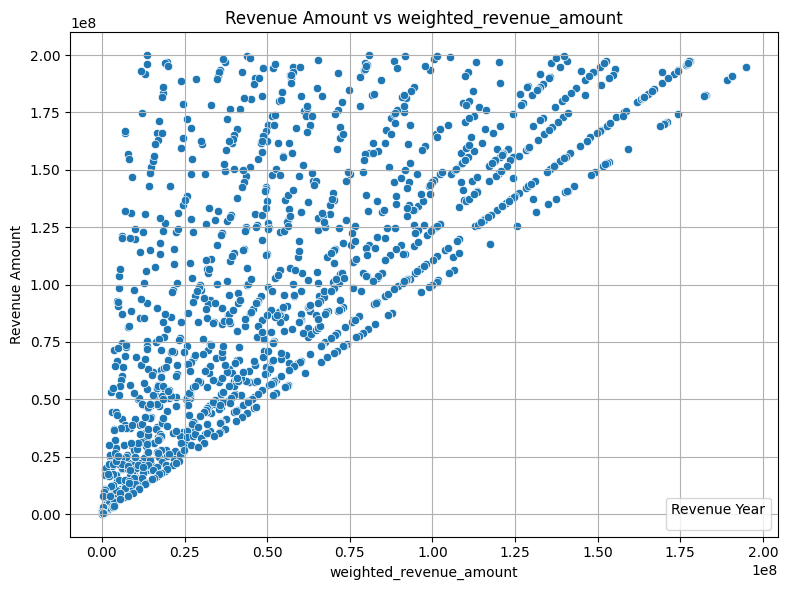


------- 3) Trends Over Time by Revenue Year -------

__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

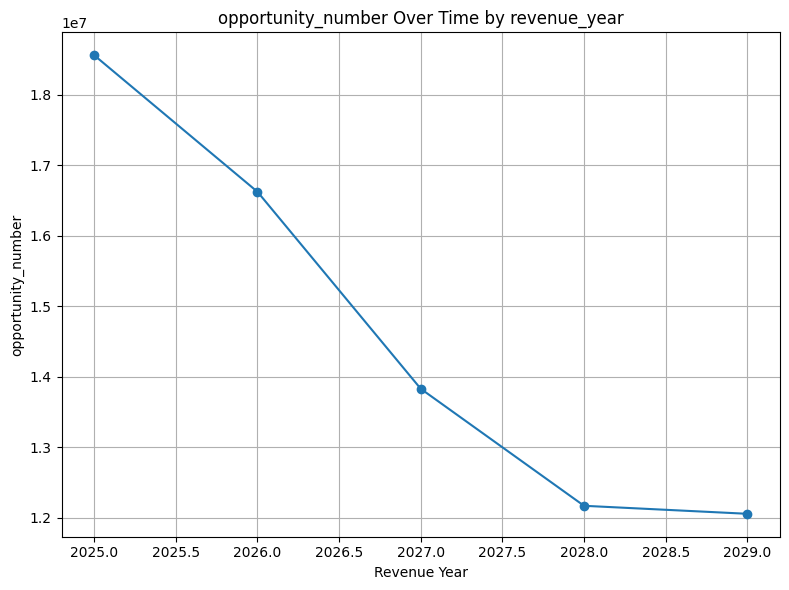


--- Trend of revenue_amount over revenue_year ---



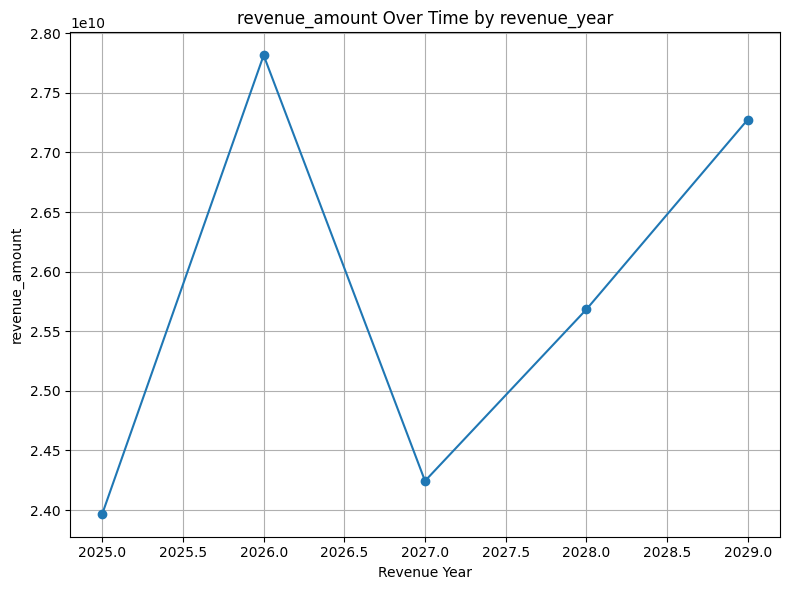


--- Trend of probability_of_award over revenue_year ---



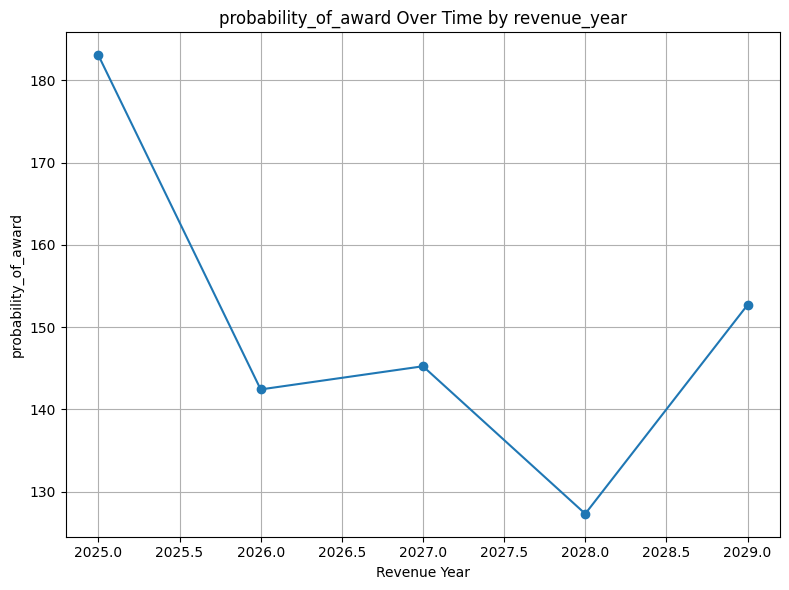


--- Trend of weighted_revenue_amount over revenue_year ---



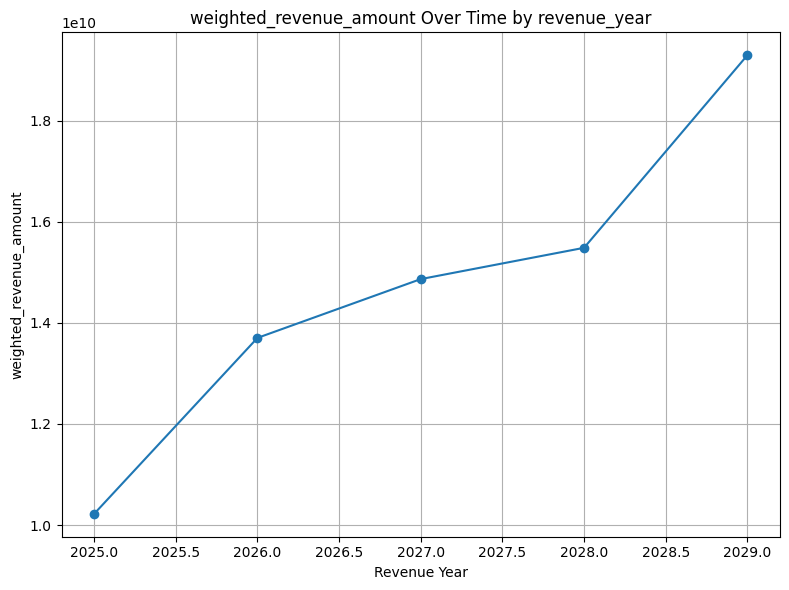

In [165]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Chunk 0: Multivariate Plots ---
print("\n------- 0) Multivariate Plots (Scatter with Hue) -------\n")
print("_" * 1000)
numeric_cols = df.select_dtypes(include='number').columns.tolist()
if 'revenue_year' in numeric_cols:
    numeric_cols.remove('revenue_year')  # used as hue

for col_x in numeric_cols:
    for col_y in numeric_cols:
        if col_x != col_y:
            print(f"\n--- Multivariate: {col_x} vs {col_y} (Hue = revenue_year) ---\n")
            plt.figure(figsize=(8, 6))
            sns.scatterplot(data=df, x=col_x, y=col_y, hue='revenue_year')
            plt.title(f"{col_y} vs {col_x} by Revenue Year")
            plt.xlabel(col_x)
            plt.ylabel(col_y)
            plt.legend(title="Revenue Year")
            plt.grid(True)
            plt.tight_layout()
            plt.show()



# --- Chunk 1: Correlation Matrix ---
print("\n------- 1) Correlation Matrix -------\n")
print("_" * 1000)
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# --- Chunk 2: Pairwise Scatter Plots vs Revenue Amount ---
print("\n------- 2) Pairwise Scatter Plots vs Revenue Amount -------\n")
print("_" * 1000)
numeric_cols = df.select_dtypes(include='number').columns.tolist()
if 'revenue_amount' in numeric_cols:
    numeric_cols.remove('revenue_amount')
if 'revenue_year' in numeric_cols:
    numeric_cols.remove('revenue_year')

for col in numeric_cols:
    print(f"\n--- Revenue Amount vs {col} ---\n")
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x=col, y='revenue_amount', hue='revenue_year')
    plt.title(f"Revenue Amount vs {col}")
    plt.xlabel(col)
    plt.ylabel("Revenue Amount")
    plt.legend(title="Revenue Year")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

print("no hue...")
print("_" * 1000)
print("\n------- 2) Pairwise Scatter Plots vs Revenue Amount -------\n")
print("_" * 1000)
numeric_cols = df.select_dtypes(include='number').columns.tolist()
if 'revenue_amount' in numeric_cols:
    numeric_cols.remove('revenue_amount')
if 'revenue_year' in numeric_cols:
    numeric_cols.remove('revenue_year')

for col in numeric_cols:
    print(f"\n--- Revenue Amount vs {col} ---\n")
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x=col, y='revenue_amount')
    plt.title(f"Revenue Amount vs {col}")
    plt.xlabel(col)
    plt.ylabel("Revenue Amount")
    plt.legend(title="Revenue Year")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# --- Chunk 3: Trends Over Time ---
print("\n------- 3) Trends Over Time by Revenue Year -------\n")
print("_" * 1000)
group_col = 'revenue_year'

for col in df.select_dtypes(include='number').columns:
    if col != group_col:
        print(f"\n--- Trend of {col} over {group_col} ---\n")
        trend_data = df.groupby(group_col)[col].sum().reset_index()
        plt.figure(figsize=(8, 6))
        plt.plot(trend_data[group_col], trend_data[col], marker='o')
        plt.title(f"{col} Over Time by {group_col}")
        plt.xlabel("Revenue Year")
        plt.ylabel(col)
        plt.grid(True)
        plt.tight_layout()
        plt.show()


# Modeling

In [166]:
...

Ellipsis

# Export Results

In [167]:
...

Ellipsis

In [168]:
# End timer
timer.stop()

Elapsed time: 0 minutes and 3 seconds
